In [1]:
import os
import time
import sys
from pathlib import Path
import torch
import numpy as np
import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C
from image_util import *
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
class MyDiffuseBSDF(psdr.BSDF):
    def __init__(self, albedo):
        psdr.BSDF.__init__(self)
        self.texture = psdr.Bitmap3fD(albedo)

    def anisotropic(self):
        return False

    def to_string(self):
        return "MyDiffuseBSDF[id=" + self.id + "]";

    def eval(self, its, wo, active):
        wo.z = drjit.mulsign(wo.z, its.wi.z);
        its.wi.z = drjit.abs(its.wi.z);
        cos_theta_i = psdr.Frame.cos_theta(its.wi)
        cos_theta_o = psdr.Frame.cos_theta(wo)
        active &= cos_theta_i > 0
        active &=  cos_theta_o > 0
        return self.texture.eval(its.uv) * psdr.InvPi * cos_theta_o & active


In [3]:
class CollocatedIntegrator():
    def __init__(self, spp, sppe, sppse, width, height, intensity):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sppe = sppe
        self.sampler = psdr.Sampler()
        if self.spp > 0:
            self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))
        self.sampler2 = psdr.Sampler()
        if self.sppe > 0:
            self.sampler2.seed(drjit.arange(UInt64C, self.sppe*self.num_pixels))
        self.intensity = intensity

    def Li(self, scene, ray, valid=True):
        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, valid)
        value = its.shape.bsdf().eval(its, its.wi, valid) / drjit.sqr(its.t)
        value *= self.intensity
        value[drjit.isnan(value)] = 0.
        value[drjit.isinf(value)] = 0.
        return value

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        result += self.render_sppe(scene, sensor_id)
        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

    def render_sppe(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.sppe == 0:
            return result
        sensor = scene.sensor[sensor_id]
        if sensor.enable_edges:
            edge_samples = sensor.sample_primary_edge(self.sampler2.next_1d());
            valid = (edge_samples.idx >= 0);
            delta_L = self.Li(scene, edge_samples.ray_n, valid) - self.Li(scene, edge_samples.ray_p, valid);
            value = edge_samples.x_dot_n*Vector3fD(delta_L/edge_samples.pdf);
            value[drjit.isnan(value)] = 0.
            value[drjit.isinf(value)] = 0.
            value /= self.sppe
            value -= drjit.detach(value)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, IntD(edge_samples.idx), valid)
        return result


In [4]:
sc = psdr.Scene()

sc.opts.spp = 64
sc.opts.sppe = 0
sc.opts.sppse = 0 
sc.opts.width = 512 
sc.opts.height = 512 

sc.opts.log_level = 0



In [5]:
sensor = psdr.PerspectiveCamera(30, 0.000001, 10000000.)
to_world = Matrix4fD([[1.,0.,0.,0.],
                     [0.,0.,-1.,5.],
                     [0.,1.,0.,0.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)

In [6]:
mybsdf = MyDiffuseBSDF("./data/texture/illya.exr")
sc.add_BSDF(mybsdf, "illya")
sc.add_Mesh("./data/uv_plane.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "illya", None, True)
sc.configure()

In [7]:
col_integrator = CollocatedIntegrator(sc.opts.spp, sc.opts.sppe, sc.opts.sppse, sc.opts.height, sc.opts.width, 100.0)

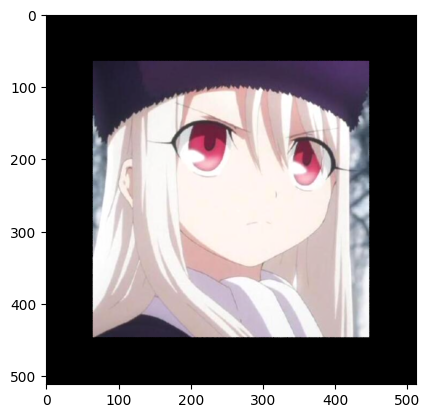

In [8]:
img_target = col_integrator.render(sc, 0)
img = img_target.numpy().reshape((sc.opts.width, sc.opts.height, 3))
img = to_srgb(np.asarray(img))
imgplot = plt.imshow(img)


In [9]:
class RenderFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, integrator, scene, sensor_id, param):
        with drjit.suspend_grad():
            scene.param_map["BSDF[0]"].texture.data = Vector3fD(param.reshape(-1,3))
            psdr_image = integrator.render(scene, 0)
            image = psdr_image.torch()
            ctx.scene = scene
            ctx.integrator = integrator
            ctx.param = param
            return image.reshape((scene.opts.height, scene.opts.width, 3))

    @staticmethod
    def backward(ctx, grad_out):
        with drjit.resume_grad():
            drjit_param = ctx.scene.param_map["BSDF[0]"].texture.data
            drjit.enable_grad(drjit_param)
            image_grad = Vector3fC(grad_out.reshape(-1,3))
            image = ctx.integrator.render(ctx.scene, 0)
            tmp = drjit.dot(image_grad, image)
            drjit.backward(tmp)
            grad_tmp = drjit.grad(drjit_param)
            drjit.disable_grad(drjit_param)
            # print(grad_tmp)
            param_grad = torch.nan_to_num(grad_tmp.torch().cuda()).reshape(512,512,3)
            return tuple([None]*3 + [param_grad])

class Renderer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, integrator, scene, sensor_id, param):
        image = RenderFunction.apply(integrator,scene,sensor_id,param)
        return image

In [10]:
psdr_render = Renderer()

opt_map = np.zeros((sc.param_map["BSDF[0]"].texture.resolution[0],sc.param_map["BSDF[0]"].texture.resolution[1],3))
opt_map = torch.tensor(opt_map, device="cuda", dtype=torch.float32).requires_grad_()
render = psdr_render(col_integrator, sc, 0, opt_map)

target_img = img_target.torch().reshape((sc.opts.width, sc.opts.height, 3))


it: 0 loss 0.15669554471969604


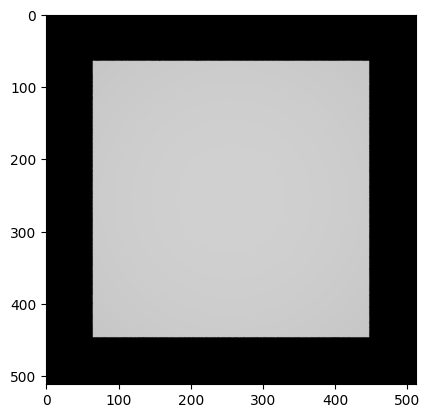

it: 1 loss 0.15581998229026794


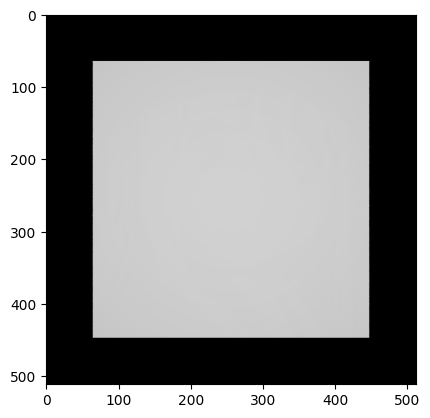

it: 10 loss 0.1413271278142929


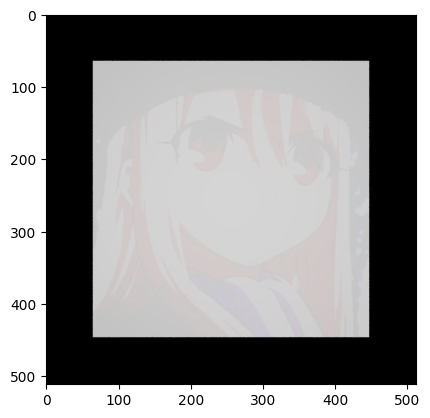

it: 20 loss 0.12690740823745728


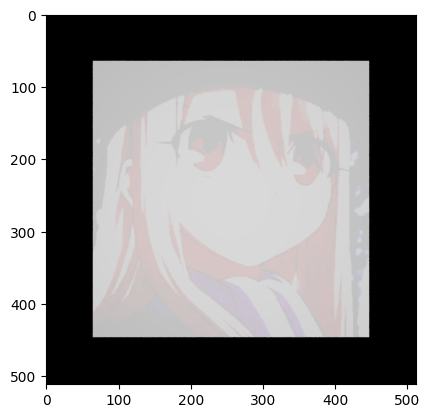

it: 30 loss 0.11333774030208588


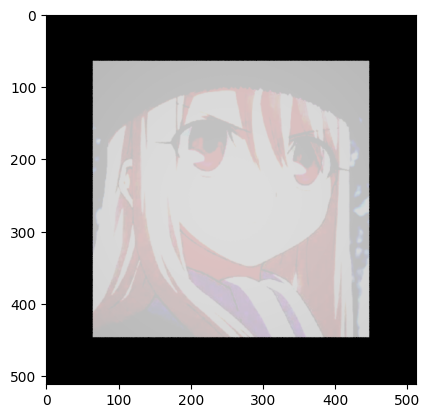

it: 40 loss 0.100985586643219


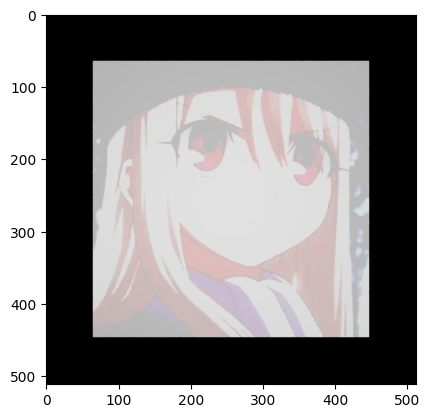

it: 50 loss 0.08967339992523193


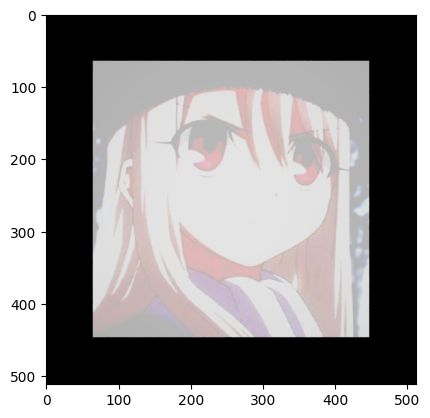

it: 60 loss 0.079311802983284


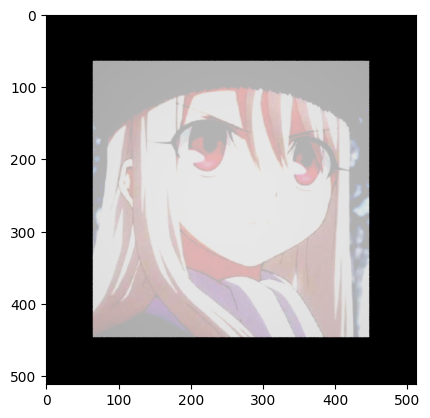

it: 70 loss 0.06981910020112991


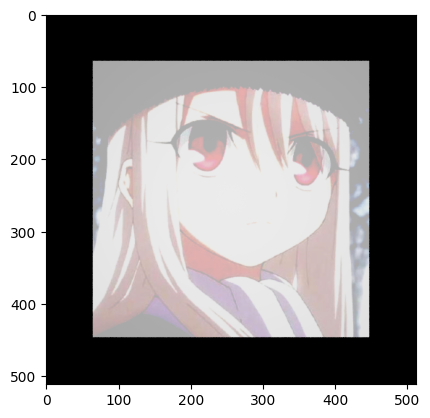

it: 80 loss 0.06121122092008591


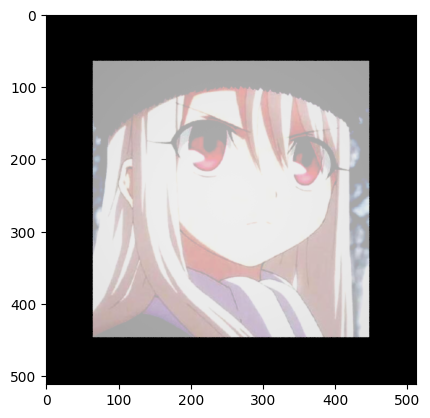

it: 90 loss 0.0534825436770916


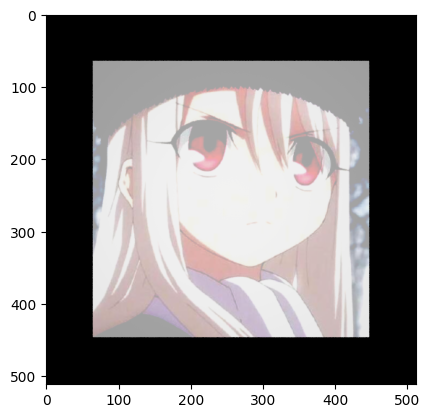

it: 100 loss 0.04672328755259514


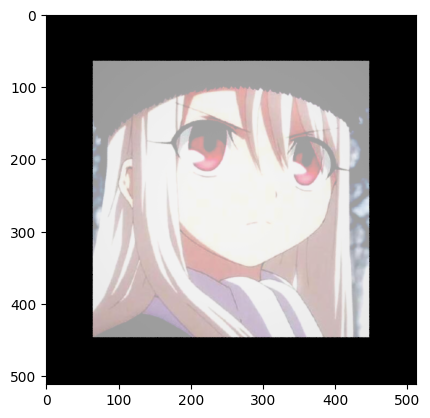

it: 200 loss 0.016171051189303398


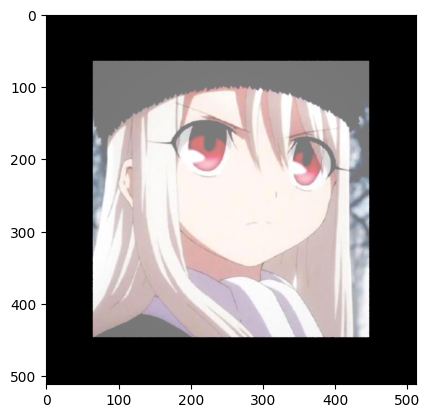

it: 300 loss 0.008008640259504318


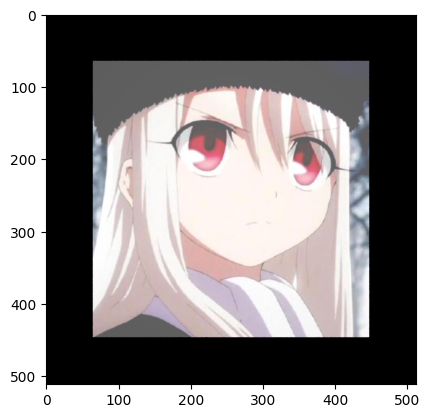

it: 400 loss 0.004272968042641878


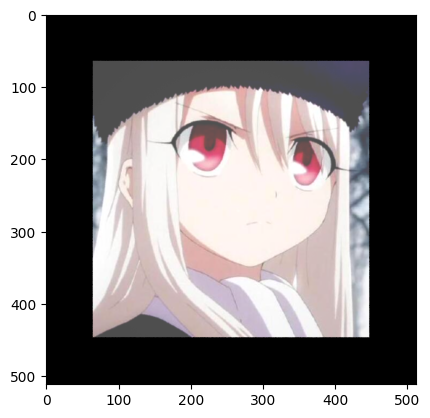

it: 500 loss 0.0024853486102074385


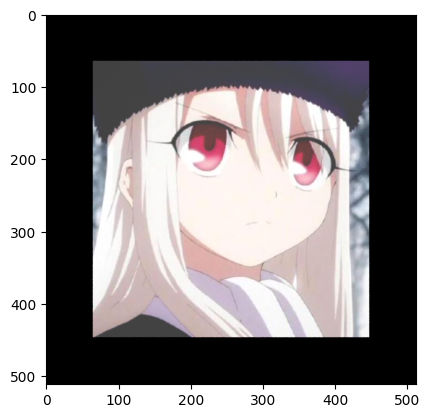

it: 600 loss 0.0016176821663975716


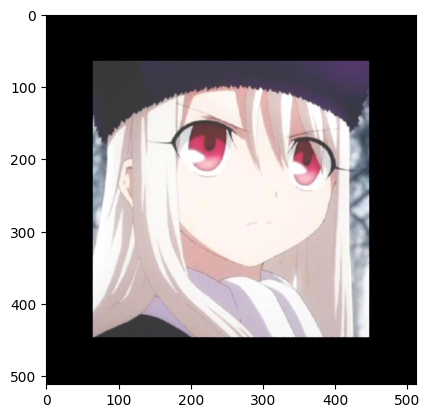

it: 700 loss 0.0011998487170785666


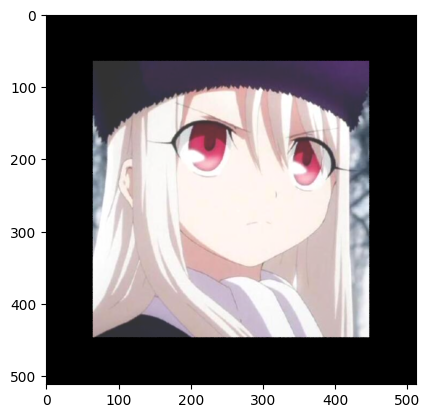

it: 800 loss 0.0009899071883410215


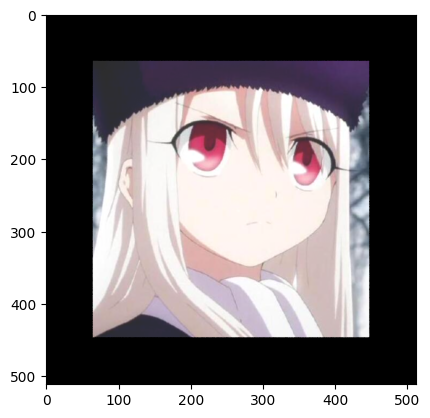

it: 900 loss 0.0008895400678738952


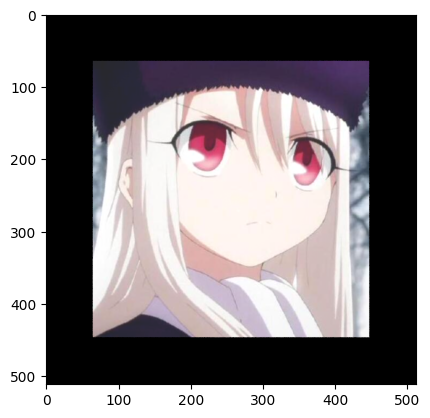

it: 1000 loss 0.0008471430046483874


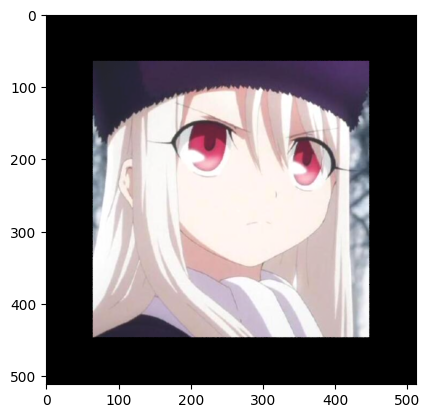

In [11]:
optimizer = torch.optim.Adam([{'params':opt_map, "lr":0.01}])
num_iter = 1000
for it in range(num_iter+1):
    optimizer.zero_grad()

    curr_img = psdr_render(col_integrator, sc, 0, torch.sigmoid(opt_map))

    loss = (target_img-curr_img).abs().mean()

    loss.backward()

    optimizer.step()

    if it % 100 == 0 or it == 1 or (it < 100 and it % 10 == 0):
        print("it:", it, "loss", loss.item())
        img = to_srgb(curr_img.detach().cpu().numpy().reshape((sc.opts.width, sc.opts.height, 3)))
        imgplot = plt.imshow(img)
        plt.show()
